In [1]:
import numpy as np
import pandas as pd
from fastai.vision import *
import torch
from PIL import Image

In [2]:
df_train = pd.read_csv('trainLabels.csv')
df_train.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [3]:
TR_PATH = 'train/'
img_enc = '.png'
df_train['id'] = [f"{TR_PATH}{o}{img_enc}" for o in df_train['id'].tolist()]
df_train.head()

,id,label
0,train/1.png,frog
1,train/2.png,truck
2,train/3.png,truck
3,train/4.png,deer
4,train/5.png,automobile


In [4]:
### GETTING IMAGE STATS

n = len(df_train)
glob_means = [0]*3
glob_squares = [0]*3

def im_to_np(i) : return np.array(Image.open(df_train['id'].iloc[i]))/255
acc_squares = lambda x : np.sum(x**2)
    
# means per channel
for im_ix in range(n) :
    im = im_to_np(im_ix)
    loc_means = [im[:,:,i].mean()/n for i in range(3)]
    glob_means = [gm + lm for gm,lm in zip(glob_means,loc_means)]

# accumulating sum of (x - mean(x))² per channel on all imgs
for im_ix in range(n) :
    im = im_to_np(im_ix)
    loc_squares = [acc_squares(im[:,:,i]-glob_means[i]) for i in range(3)]
    glob_squares = [gs + ls for gs,ls in zip(glob_squares,loc_squares)]
    
# standard deviations of channels
glob_stds = [np.sqrt(o/(n*32*32)) for o in glob_squares]
stats = [torch.Tensor(glob_means),torch.Tensor(glob_stds)]

In [5]:
stats

[tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616])]

In [6]:
db = (ImageDataBunch.from_df(path='.',df=df_train,label_col='label',
                             ds_tfms = [flip_lr(),[]],valid_pct=0.3,bs=256)
      .normalize(stats = stats))

Layers

In [13]:
def conv_lay(ni,nf,s=1,ks=3,padding=0, depthwise = False, act = True, zero_bn = False) :
    """Base conv layer, followed by Bn and an activation."""
    # 'ni': number of input channels
    # 'nf': number of filters
    # 's': stride
    # 'ks': kernel size
    if isinstance(ks,tuple) :
        padding = (ks[0]//2,ks[1]//2)
    else : padding = ks //2
    bn = nn.BatchNorm2d(nf)
    # Initialization trick from https://arxiv.org/pdf/1901.09321.pdf
    # Not part of efficientnet AFAIK but better weight init should improve result anyway
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    if act :
        return nn.Sequential(
            nn.Conv2d(ni,nf,ks,stride=s,padding=padding,bias=False,groups= ni if depthwise else 1), 
            bn,
            nn.ReLU6(inplace=True))
    else :
        return nn.Sequential(
            nn.Conv2d(ni,nf,ks,stride=s,padding=padding,bias=False,groups= ni if depthwise else 1), 
            bn)

class mbconv_downsample(nn.Module):
    # From https://arxiv.org/pdf/1801.04381.pdf
    # Hopefully that's how they downsample in efficientnet, it's not told in the paper
    def __init__(self, ni, nf, ks=(3,3)):
        super().__init__()
        self.conv1 = conv_lay(ni,nf,ks=1)
        self.conv2 = conv_lay(nf,nf,ks=ks,s=2,depthwise=True)
        self.conv3 = conv_lay(nf,nf,ks=1,act=False)
        
    def forward(self,x) :
        return self.conv3(self.conv2(self.conv1(x)))

class mbconv(nn.Module) :
    """Base inverted mobile resnet block"""
    def __init__(self,ni,nf,exp=6, ks=(3,3)) :
        super().__init__()
        self.ni = ni
        self.nf = nf
        self.conv1 = conv_lay(ni,nf,ks=1)
        self.conv2 = conv_lay(nf,nf*exp,ks=ks,depthwise=True)
        self.conv3 = conv_lay(nf*exp,nf,ks=1,act=False, zero_bn = True)
        if ni != nf: self.conv4 = conv_lay(ni,nf,ks=1,act=False)
        
    def forward(self,x) :
        return self.conv3(self.conv2(self.conv1(x))) + self.conv4(x) if self.ni != self.nf else x

    
# MISSING: Squeeze and exication optimization, probably from  
# https://arxiv.org/pdf/1709.01507.pdf
# Should be added to the basic mbconv, as per comment in 
# https://arxiv.org/pdf/1905.11946.pdf below table 1

In [14]:
# see table 1 in https://arxiv.org/pdf/1905.11946.pdf
filters = [32,16,24,40,80,112,192,320]
downsample_blocks = [1,3,6] # [1,2,3,6] for imagenet

# Copy pasted from https://github.com/fastai/fastai/blob/master/fastai/vision/models/xresnet.py
# Sort of fixup initialization from https://arxiv.org/pdf/1901.09321.pdf but using Batchnorm
# Not part of efficientnet AFAIK but better weight init should improve result anyway
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

class nnet(nn.Module) :
    """Base resnet-like model"""
    def make_block(self,ni,nf,n,exp,ks=(3,3),s=1,downsample=False) :
        """conv + n*mbconv3"""
        l = [mbconv(ni,nf,exp,ks)]
        l += [mbconv(nf,nf,exp,ks) for _ in range(n-1)]
        if downsample :
            print(downsample)
            l = l[:-1] + [mbconv_downsample(nf,nf)]
        return l
    
    def __init__(self,blocks,n_classes=10):
        super().__init__()
        layers = [conv_lay(3,filters[0],s=2)]
        for ix,n in enumerate(blocks) :
            exp = 1 if ix == 0 else 6
            ks = (5,5) if ix == 2 else (3,3)
            downsample = ix in downsample_blocks
            layers += self.make_block(filters[ix],filters[ix+1],n,exp = exp,
                                      ks = ks, downsample = downsample)
        layers += [nn.AdaptiveAvgPool2d(1)]
        layers += [Flatten(),nn.Dropout(0.2),nn.Linear(filters[ix+1],n_classes)]
        self.layers = nn.Sequential(*layers) #
        self.c = n_classes
        init_cnn(self)
    
    def forward(self,x) :
        return self.layers(x) 

Network archi

In [15]:
blocks = [1,2,2,3]
# Actual efficientnet has blocks = [1,2,2,3,3,4,1] but can't do that with cifar
mod = nnet(blocks)
mod

True
True


nnet(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace)
    )
    (1): mbconv(
      (conv1): Sequential(
        (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace)
      )
      (conv2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace)
      )
      (conv3): Sequential(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv4): Sequential(
  

In [16]:
learn = Learner(db,mod,metrics=accuracy)#.mixup()
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 16, 16]         864        True      
______________________________________________________________________
BatchNorm2d          [32, 16, 16]         64         True      
______________________________________________________________________
ReLU6                [32, 16, 16]         0          False     
______________________________________________________________________
Conv2d               [16, 16, 16]         512        True      
______________________________________________________________________
BatchNorm2d          [16, 16, 16]         32         True      
______________________________________________________________________
ReLU6                [16, 16, 16]         0          False     
______________________________________________________________________
Conv2d               [16, 16, 16]         144        True      
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


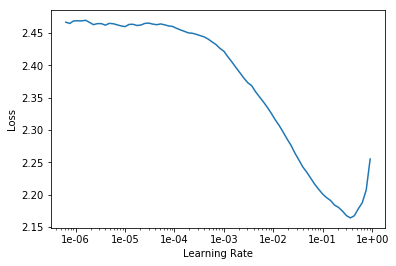

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(100,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.940101,1.820048,0.335467,00:06
1,1.722696,1.631568,0.406600,00:06
2,1.558076,1.493928,0.454467,00:06
3,1.438359,1.395729,0.489533,00:06
4,1.337923,1.333208,0.513600,00:06
5,1.256165,1.287364,0.528133,00:06
6,1.170217,1.235951,0.552800,00:06
7,1.109211,1.173454,0.576867,00:06
8,1.046061,1.156415,0.585133,00:06
9,0.982230,1.100935,0.607933,00:06
